## Generate Light Curve
$SF_\infty = \hat{\sigma} \sqrt{\tau}$ and $\sigma = \hat{\sigma} \sqrt{\tau / 2} = SF_\infty / \sqrt{2}$.

In [35]:
import numpy as np

# set parameters
tau = 100 #signal decorrelation timescale in days
sf = 0.2
sigma_hat = sf/np.sqrt(tau) # modified variability amplitude
sigma = sf/np.sqrt(2)
delta_t = 2 # observational cadence delta_t = t_i+1 - t_i

s = np.zeros(2000)
t = 0

while t < 2000:
    if t == 0:
        s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
        t = t + 1
        # print('Here! t = ' + str(t))
    else:
        s[t] = s[t-1]*np.exp(-delta_t/tau) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/tau)))
        t = t + 1
        # print('Here! t = ' + str(t))

# light curve is actually s + Gaussian noise + mean magnitude

mean_mag = 18 #mean mag
photometric_noise = np.random.normal(loc=0,scale=0.01,size=len(s))

y = s + mean_mag + photometric_noise


## Plot DRW Light Curve

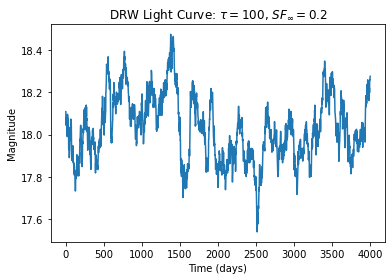

In [36]:
from matplotlib import rc
import matplotlib

### LaTeX Font for plotting ###
# rc('font', **{'family': 'sans-serif', 'sans-serif': ['Times-Roman']})
# rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
# matplotlib.rcParams.update({'font.size': 11})
##########

import matplotlib.pyplot as plt
# %matplotlib widget

t = range(0,4000,2)

plt.plot(t,y)
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')
plt.title('DRW Light Curve: $\\tau = {}$'.format(tau) + ', $SF_\\infty = {}$'.format(sf))

plt.show()
# plt.savefig("Report Figures/drw-light-curve.pdf", bbox_inches='tight')


## Export to .dat
Three column format with (1) epoch, (2) magnitude/light curve value and (3) uncertainty on point.

In [37]:
import struct
import pandas as pd

slicage = 400

epochs = list(t)
epochs_sliced = epochs[0:slicage]
points_sliced = y[0:slicage]

the_data = np.zeros((slicage,3))
the_data[:slicage,0] = epochs_sliced
the_data[:slicage,1] = points_sliced

df = pd.DataFrame(the_data)
print(df)
df.to_csv('nice_rig.dat',header=False,index=False,sep=' ')

         0          1    2
0      0.0  18.108977  0.0
1      2.0  18.084280  0.0
2      4.0  18.068230  0.0
3      6.0  18.043459  0.0
4      8.0  18.079351  0.0
..     ...        ...  ...
395  790.0  18.277866  0.0
396  792.0  18.304852  0.0
397  794.0  18.317348  0.0
398  796.0  18.276061  0.0
399  798.0  18.250298  0.0

[400 rows x 3 columns]


## Interpret Light Curve with JAVELIN
### Plot the Curve with JAVELIN

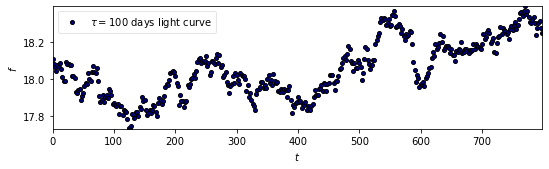

True

In [38]:
from javelin.zylc import get_data
javdata = get_data(["nice_rig.dat"], names=["$\\tau = 100$ days light curve",])
javdata.plot()

### MCMC the Light Curve

In [39]:
from javelin.lcmodel import Cont_Model
cont = Cont_Model(javdata)

cont.do_mcmc(fchain="mychain0.dat",flogp="mylogp.dat")
# nwalkers=8,nburn=10,nchain=10,


start burn-in
nburn: 50 nwalkers: 100 --> number of burn-in iterations: 5000
burn-in finished
start sampling
sampling finished
acceptance fractions for all walkers are
0.84 0.68 0.64 0.62 0.62 0.56 0.80 0.70 0.72 0.78 0.68 0.62 0.78 0.78 0.88 0.68 0.78 0.78 0.72 0.70 0.78 0.74 0.74 0.78 0.78 0.78 0.70 0.62 0.66 0.72 0.86 0.64 0.84 0.66 0.72 0.70 0.76 0.74 0.78 0.62 0.82 0.76 0.60 0.68 0.56 0.60 0.78 0.48 0.76 0.68 0.82 0.80 0.76 0.78 0.74 0.82 0.76 0.62 0.66 0.66 0.74 0.74 0.74 0.84 0.68 0.80 0.66 0.58 0.78 0.62 0.70 0.74 0.80 0.82 0.70 0.64 0.74 0.74 0.70 0.64 0.74 0.76 0.48 0.82 0.66 0.76 0.56 0.66 0.70 0.50 0.76 0.58 0.66 0.72 0.66 0.72 0.80 0.84 0.82 0.72
save MCMC chains to mychain0.dat
save logp of MCMC chains to mylogp.dat
HPD of sigma
low:    0.129 med    0.155 hig    0.200
HPD of tau
low:   58.950 med   85.833 hig  144.019


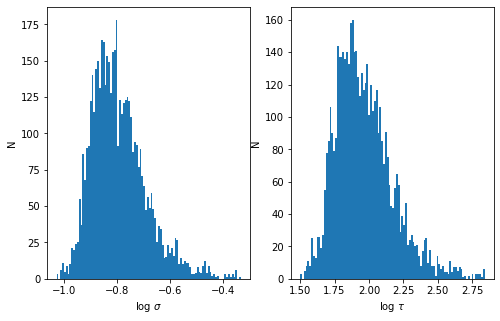

HPD of sigma
low:    0.129 med    0.155 hig    0.200
HPD of tau
low:   58.950 med   85.833 hig  144.019
None


In [40]:
cont.show_hist(bins=100)

conthpd = cont.get_hpd()
print(conthpd)
#truths
# true_sigma = np.log(sigma)
# true_tau = np.log(tau)

# Previous attempts

In [ ]:
# covariance matrix
S = np.zeros((len(t),len(t)))
for i in range(0,len(t)):
    for j in range(0,len(t)):
        S[i,j] = sigma**2 * np.exp(-np.abs(t[i] - t[j]) / tau)

# response matrix L (actually a column vector)
L = np.ones((len(y), 1))
# linear coefficient representing the light curve mean
q = mean_mag
C = S + np.eye((len(S)))

C_inverse = np.linalg.inv(C)
bracket = np.matmul(np.matmul(L.T, C_inverse), L)
bracket_inverse = np.linalg.inv(bracket)
rh_term = np.matmul(
    np.matmul(np.matmul(np.matmul(C_inverse, L), bracket_inverse), L.T), C_inverse)
C_perp_inverse = C_inverse - rh_term

likelihood = (np.linalg.det(C))**(-0.5) * np.linalg.det(bracket)**(-0.5) * np.exp(- np.matmul(np.matmul(y.T,C_perp_inverse),y) / 2)

In [87]:
# idk how Bayesian model fitting will work for a damped random walk... but anyway
import scipy.stats as sts
import dynesty
# from dynesty import plotting as dyplot

def model(time_scale,amp):
    sigma = amp*np.sqrt(time_scale/2)
    t=0
    s = np.zeros(2000)
    while t < 2000:
        if t == 0:
            s[t] = np.random.normal(loc=0,scale=sigma) #for the 0th point, draw from Gaussian deviate of width sigma
            t = t + 1
            # print('Here! t = ' + str(t))
        else:
            s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
            t = t + 1
    return s + 18
            # print('Here! t = ' + str(t))

def prior_transform(uTheta):
    uTime_scale, uAmp = uTheta
    time_scale = 150*uTime_scale # uniform between 0 and 150
    amp = 0.1*uAmp # uniform between 0 and 0.1
    return time_scale, amp

def lnlike(Theta):
    time_scale, amp = Theta
    y_val = model(time_scale,amp)
    return sum(sts.norm.logpdf(y,loc=y_val,scale=sigma))
    
dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=2)
dsampler.run_nested(print_progress=True)


    

4568it [1:37:53,  3.09s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010] Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/dynesty/dynesty.py", line 982, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 29, in lnlike
    y_val = model(time_scale,amp)
  File "/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_67928/3030410087.py", line 16, in model
    s[t] = s[t-1]*np.exp(-delta_t/time_scale) + np.random.normal(loc=0,scale=sigma*np.sqrt(1-np.exp(-2*delta_t/time_scale)))
KeyboardInterrupt
4568it [1:37:53,  1.29s/it, batch: 0 | bound: 867 | nc: 228 | ncall: 817007 | eff(%):  0.559 | loglstar:   -inf < 975.646 <    inf | logz: 962.771 +/-  0.217 | dlogz: 294.575 >  0.010]

Exception while calling loglikelihood function:
  params: [5.52139114e+01 1.19443173e-02]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [72]:
(s*s).mean()

0.02071170391231226

In [74]:
s.var()

0.02050307097315799

array(0.00088429)